In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
filepath = "iot23_combined.csv"
df = pd.read_csv(filepath)

In [4]:
pd.set_option('display.max_columns', None)

df

,Unnamed: 0,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,3,34243.0,49560.0,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4,34840.0,21288.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,14,34243.0,49560.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,27,34243.0,49560.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,44,33685.0,34797.0,2.998560,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240248,2049,41182.0,443.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Torii,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1240249,2050,41182.0,443.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Torii,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1240250,2052,41184.0,443.0,3.104980,0,0,0.0,3.0,180.0,0.0,0.0,Torii,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1240251,3143,41184.0,443.0,29513.600849,14734,14734,5390.0,5895.0,248182.0,6147.0,257816.0,Torii,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
del df['Unnamed: 0']

In [6]:
df['label'].value_counts()

Mirai            391121
Kenjiro          197416
IRCBot           196828
Benign           192099
Okiru             99978
Gagfyt            99516
Hide and Seek     55043
Hakai              8222
Torii                30
Name: label, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df[['id.orig_p','id.resp_p','duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values

In [10]:
X.shape

(583220, 26)

In [11]:
Y = pd.get_dummies(df['label']).values

In [12]:
Y.shape

(583220, 2)

In [13]:
# X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']]
# Y = df[['label']]

In [14]:
X

array([[ 3.424300e+04,  4.956000e+04,  2.998804e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.484000e+04,  2.128800e+04,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.424300e+04,  4.956000e+04,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       ...,
       [ 4.626600e+04,  2.300000e+01, -1.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 5.295200e+04,  2.300000e+01, -1.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 4.452800e+04,  2.300000e+01, -1.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

In [15]:
df

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,34243.0,49560.0,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,34840.0,21288.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,34243.0,49560.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,34243.0,49560.0,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,33685.0,34797.0,2.998560,0,0,0.0,3.0,180.0,0.0,0.0,Benign,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583215,42204.0,23.0,-1.000000,-1,-1,0.0,6.0,360.0,0.0,0.0,Mirai,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
583216,42010.0,23.0,-1.000000,-1,-1,0.0,6.0,360.0,0.0,0.0,Mirai,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
583217,46266.0,23.0,-1.000000,-1,-1,0.0,6.0,360.0,0.0,0.0,Mirai,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
583218,52952.0,23.0,-1.000000,-1,-1,0.0,6.0,360.0,0.0,0.0,Mirai,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(X)

MinMaxScaler()

In [18]:
normalized_x = scaler.transform(X)

In [19]:
normalized_x

array([[5.24563795e-01, 7.56237125e-01, 8.16452034e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.33709156e-01, 3.24834058e-01, 2.04174057e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.24563795e-01, 7.56237125e-01, 2.04174057e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.08742475e-01, 3.50957504e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.11164387e-01, 3.50957504e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.82118292e-01, 3.50957504e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [20]:
normalized_x.shape

(583220, 26)

In [21]:
scaler.fit(Y)

MinMaxScaler()

In [22]:
normalized_y = scaler.transform(Y)

In [23]:
normalized_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_x, normalized_y, random_state=10, test_size=0.2)

In [25]:
X_train.shape

(466576, 26)

In [26]:
model = Sequential()

In [27]:
model.add(Dense(1024, activation='relu',input_dim=26))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              27648     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

In [29]:
import time

In [30]:
start = time.time()
print('program start...')
print()

history = model.fit(
    X_train, 
    Y_train, 
    epochs = 10, 
    batch_size=1024, 
    validation_data=(X_test,Y_test),
    verbose=1)

print()
end = time.time()
print('program end...')
print()
print('time cost: ')
print(end - start, 'seconds')

program start...

Epoch 1/10
456/456 [==============================] - 8s 18ms/step - loss: 0.3215 - accuracy: 0.8104 - val_loss: 0.2697 - val_accuracy: 0.8228
Epoch 2/10
456/456 [==============================] - 8s 17ms/step - loss: 0.2651 - accuracy: 0.8244 - val_loss: 0.2588 - val_accuracy: 0.8239
Epoch 3/10
456/456 [==============================] - 8s 18ms/step - loss: 0.2589 - accuracy: 0.8261 - val_loss: 0.2571 - val_accuracy: 0.8264
Epoch 4/10
456/456 [==============================] - 8s 17ms/step - loss: 0.2575 - accuracy: 0.8268 - val_loss: 0.2556 - val_accuracy: 0.8270
Epoch 5/10
456/456 [==============================] - 8s 17ms/step - loss: 0.2563 - accuracy: 0.8263 - val_loss: 0.2543 - val_accuracy: 0.8246
Epoch 6/10
456/456 [==============================] - 8s 18ms/step - loss: 0.2591 - accuracy: 0.8246 - val_loss: 0.2738 - val_accuracy: 0.8118
Epoch 7/10
456/456 [==============================] - 8s 18ms/step - loss: 0.2588 - accuracy: 0.8258 - val_loss: 0.2530 - va

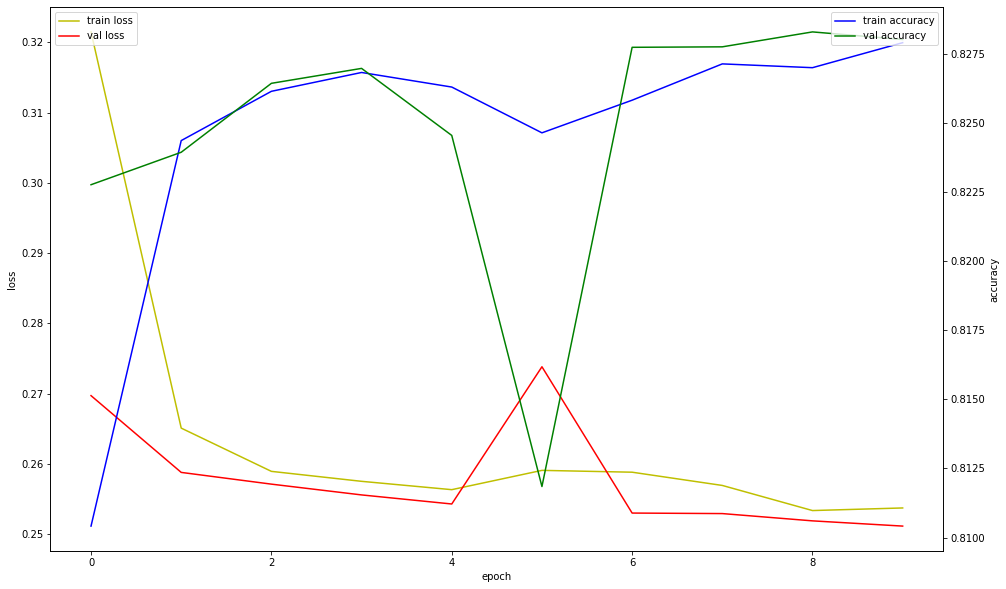

In [31]:
fig, loss_ax = plt.subplots(figsize = (16,10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [32]:
model.save('model.h5')

In [33]:
new_model = tf.keras.models.load_model('model.h5')

In [34]:
Y_test.shape

(116644, 2)

In [35]:
X_test.shape

(116644, 26)

In [36]:
test_loss, test_acc = new_model.evaluate(X_test, Y_test, verbose=1)

3646/3646 [==============================] - 3s 728us/step - loss: 0.2512 - accuracy: 0.8280


In [37]:
y_pred = new_model.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classifiction Report :")
print(classification_report(Y_test, y_pred))

Classifiction Report :


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets